In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor

import tqdm
import matplotlib.pyplot as plt
from typing import Tuple

from Simulation import Simulation

# Show all available GPUs
print(torch.cuda.get_device_name(0))

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print('=============')
# Set default tensor type to cuda.FloatTensor if GPU is available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("Using GPU")
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    print("Using CPU")


# Set seed for reproducibility
torch.manual_seed(0)

NVIDIA GeForce RTX 2060
cuda:0
Using GPU


In [29]:
class Trolley:
	def __init__(self, mass: Tensor, friction: Tensor, dt: Tensor) -> None:
		"""
		Initialize the trolley

		Args:
			mass (float): mass of the trolley
			friction (float): friction coefficient of the trolley
			dt (float): time step between the current and previous position

		Returns:
			None
		"""
		self.mass: Tensor = torch.tensor(mass, dtype=torch.float32, device=device)
		self.friction: Tensor = torch.tensor(friction, dtype=torch.float32, device=device)
		self.spring_constant: Tensor = torch.tensor(50, dtype=torch.float32, device=device)
		self.dt: Tensor = torch.tensor(dt, dtype=torch.float32, device=device)
		self.position: Tensor = torch.tensor(0, dtype=torch.float32, device=device)
		self.delta_position: Tensor = torch.tensor(0, dtype=torch.float32, device=device)
		self.velocity: Tensor = torch.tensor(0, dtype=torch.float32, device=device)
		self.F: Tensor = torch.tensor(50, dtype=torch.float32, device=device)


	def update(self, control_output: Tensor, distrubance: Tensor = torch.tensor(0.)) -> None:
		"""
		Update the position and velocity of the trolley
		
		Args:
			TODO: select best unit for the demonstration
		
		Returns:
			None
			
		Equation of model:
            F = ma
            a = F/m
            a = F/m - friction*v/m
            v = v + a*dt
            x = x + v*dt
		"""
		F = control_output
		acceleration = F / self.mass - self.friction * self.velocity / self.mass - self.spring_constant * self.delta_position / self.mass
		self.velocity += acceleration * self.dt
		position = self.position + self.velocity * self.dt
		self.delta_position = position - self.position
		self.position = position


	def get_position(self) -> Tensor:
		"""
		Get the position of the trolley

		Args:
			None

		Returns:
			float: position of the trolley
		"""
		return self.position
	

	def get_U(self) -> Tuple[Tensor, Tensor, Tensor]:
		return self.position, self.position/self.dt, self.position/(self.dt**2)
	

	def reset(self) -> None:
		"""
		Reset the position and velocity of the trolley

		Args:
			None

		Returns:
			None
		"""
		self.position = torch.tensor(0, dtype=torch.float32, device=device)
		self.velocity = torch.tensor(0, dtype=torch.float32, device=device)
		self.delta_position = torch.tensor(0, dtype=torch.float32, device=device)


class PID:
	"""PID controller class"""
	def __init__(self, KP: Tensor, KI: Tensor, KD: Tensor) -> None:
		"""
		A PID controller is characterized by three parameters: proportional gain (KP), integral gain (KI), and derivative gain (KD).
		
		Args:
            KP (float): proportional gain
            KI (float): integral gain
            KD (float): derivative gain
		"""
		# PID parameters
		self.KP: Tensor = torch.tensor(KP, dtype=torch.float32, device=device)
		self.KI: Tensor = torch.tensor(KI, dtype=torch.float32, device=device)
		self.KD: Tensor = torch.tensor(KD, dtype=torch.float32, device=device)

        # PID states
		self.error: Tensor = torch.tensor(0, dtype=torch.float32, device=device)
		self.error_last: Tensor = torch.tensor(0, dtype=torch.float32, device=device)
		self.integral_error: Tensor = torch.tensor(0, dtype=torch.float32, device=device)
		self.derivative_error: Tensor = torch.tensor(0, dtype=torch.float32, device=device)

		# PID saturation limits
		self.saturation_max: Tensor = torch.tensor(5, dtype=torch.float32, device=device)
		self.saturation_min: Tensor = torch.tensor(-5, dtype=torch.float32, device=device)
	
    
	def compute(self, target: Tensor, position: Tensor, dt: Tensor) -> Tensor:
		"""
		Calculate the output of the PID controller
		
		Args:
            target (float): target value
			position (float): current value
			dt (float): time step between the current and previous position
			
        Returns:
            float: output of the PID controller
		"""
		# Calculate the errors
		self.error = target - position # error = target - current
		self.integral_error += self.error * dt #error build up over time
		self.derivative_error = (self.error - self.error_last) / dt #find the derivative of the error (how the error changes with time)
		self.error_last = self.error # update the error
		
		# Calculate the output
		output = \
			self.KP * self.error + \
			self.KI * self.integral_error + \
			self.KD * self.derivative_error

		if output > self.saturation_max and self.saturation_max:
			output = self.saturation_max
		elif output < self.saturation_min and self.saturation_min:
			output = self.saturation_min
		return output


	def setLims(self, min: Tensor, max: Tensor) -> None:
		"""
		Set the saturation limits for the PID controller
		
		Args:
            min (float): minimum value of the output
            max (float): maximum value of the output
			
        Returns:
            None
		"""
		self.saturation_max = max
		self.saturation_min = min


In [30]:
# Defining the architecture of the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(7, 3).to(device)
        self.fc2 = nn.Linear(3, 3).to(device)
        self.activation = nn.ELU(alpha=0.7)  # Add ELU activation function

    def forward(self, x) -> Tensor:
        x = self.activation(self.fc1(x)).to(device)  # Apply activation function to fc1 layer
        x = self.activation(self.fc2(x)).to(device)  # Apply activation function to fc2 layer
        return x


class CustomResidualBlock(nn.Module):
    def __init__(self):
        super(CustomResidualBlock, self).__init__()
        # Используем линейные слои вместо Conv2d
        self.linear1 = nn.Linear(7, 3)
        self.linear2 = nn.Linear(3, 3)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x += residual
        x = self.relu(x)
        return x


# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted_Y: Tensor, input_X: Tensor, vector_E: Tensor, K: Tensor, dt: Tensor):
        """
        Args:
            predicted_Y (tensor): coeeficients of the PID controller (KP, KI, KD)
            input_X (tensor): X(t) = [x(t), x(t-1), u(t), u(t-1)]
            error (tensor): error between the target and current position
            dt (float): time step between the current and previous position

        Returns:
            loss (tensor): loss function
        """
        x_t = input_X[0]
        x_t_1 = input_X[1]
        u_t = input_X[2]
        u_t_1 = input_X[3]

        dxdt = (x_t_1 - x_t) / dt
        dudt = (u_t_1 - u_t) / dt

        Kp_t = K[0]
        Kp_t_1 = K[1]
        delta_Kp = Kp_t_1 - Kp_t
        Ki_t = K[2]
        Ki_t_1 = K[3]
        delta_Ki = Ki_t_1 - Ki_t
        Kd_t = K[4]
        Kd_t_1 = K[5]
        delta_Kd = Kd_t_1 - Kd_t

        E_t = vector_E[0]
        E_t_1 = vector_E[1]
        delta_E = E_t_1 - E_t

        # loss = torch.mean(((delta_E/delta_Kp)**2 + (delta_E/delta_Ki)**2 + (delta_E/delta_Kd)**2)**(1/2))
        # loss= torch.mean(((delta_E/dt)**2 + (delta_Kp/dt)**2 + (delta_Ki/dt)**2 + (delta_Kd/dt)**2))
        loss= torch.mean(((delta_E/dt)**2))


        # mse_loss = torch.mean(error**2).to(device)
        # control_loss = torch.mean((u_t_1-u_t)**2).to(device)
        # loss = mse_loss + control_loss


        # loss = torch.mean((dxdt)**2)
        return loss


### Creating the model, loss function and optimizer

In [31]:
# Model
# model = NeuralNetwork()
model = CustomResidualBlock()

# Loss function
custom_loss = CustomLoss()

# Optimizers
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001)
# optimizer = optim.Adadelta(model.parameters(), lr=0.1)

### Class for simulation env

In [32]:
class SimulationNN(Simulation):
	def __init__(self, time: Tensor, target: Tensor, disturbance: Tensor, dt: Tensor = torch.tensor(0.01)) -> None:
		super().__init__(time, target, disturbance, dt)
		self.model = None
		self.custom_loss = None
		self.optimizer = None

		self.feedback_Kp = torch.zeros(len(time))
		self.feedback_Ki = torch.zeros(len(time))
		self.feedback_Kd = torch.zeros(len(time))


	def run(self, trolley: Trolley, pid: PID) -> None:

		# Check if the model, loss function, and optimizer are defined
		if self.model is None or self.custom_loss is None or self.optimizer is None:
			raise Exception("Model, loss function, or optimizer is not defined")

		# This cycle like the one epoc in the training
		with tqdm.tqdm(total=len(self.time)-1) as pbar:
			pbar.colour = 'green'
			for i in range(1, len(self.time)):
				# Get data from the previous step
				target = self.target[i]
				disturbance = self.disturbance[i]
				position = trolley.get_position()

				# PID controller
				pid.KP = self.feedback_Kp[i-1]
				pid.KI = self.feedback_Ki[i-1]
				pid.KD = self.feedback_Kd[i-1]
				control_output = pid.compute(target, position, self.dt)
				self.feedback_U[i] = control_output

				# Update the trolley
				trolley.update(control_output, disturbance)

				# Get the current position
				new_position = trolley.get_position()
				self.feedback_X[i] = new_position

				# Reset gradient
				self.optimizer.zero_grad()

				# Build input vector X
				X_t = self.feedback_X[i]
				X_t_1 = self.feedback_X[i-1]
				U_t = self.feedback_U[i]
				U_t_1 = self.feedback_U[i-1]
				T_t = self.target[i]
				T_t_1 = self.target[i-1]
				E = self.target[i] - self.feedback_X[i]

				input_X = torch.tensor([X_t, X_t_1, U_t, U_t_1, T_t, T_t_1, E], dtype=torch.float32, requires_grad=True).to(device)

				# Predict the next coeeficients of the PID controller
				predicted_Y = self.model(input_X)
				Kp = predicted_Y[0].item()
				Ki = predicted_Y[1].item()
				Kd = predicted_Y[2].item()

				# Save the coefficients
				self.feedback_Kp[i] = Kp
				self.feedback_Ki[i] = Ki
				self.feedback_Kd[i] = Kd

				# Vector of K coefficients
				Kp_t = self.feedback_Kp[i]
				Kp_t_1 = self.feedback_Kp[i-1]
				Ki_t = self.feedback_Ki[i]
				Ki_t_1 = self.feedback_Ki[i-1]
				Kd_t = self.feedback_Kd[i]
				Kd_t_1 = self.feedback_Kd[i-1]

				K = torch.tensor([Kp_t, Kp_t_1, Ki_t, Ki_t_1, Kd_t, Kd_t_1], dtype=torch.float32, requires_grad=True).to(device)

				# Calculate the error
				E_t = target - new_position
				E_t_1 = self.feedback_E[i-1]
				self.feedback_E[i] = E_t
				vector_E = torch.tensor([E_t, E_t_1], dtype=torch.float32, requires_grad=True).to(device)
				
				# Calculate the loss
				loss = self.custom_loss(
					predicted_Y, input_X, vector_E, K,
					self.dt
					)

				# Backpropagation
				loss.backward()

				# Update the weights
				self.optimizer.step()

				# Update the progress bar
				pbar.update(1)
				pbar.set_description(f"Loss: {loss.item():.4f}  ||  X_pred: {X_t:.4f}, X_targ: {target:.4f}  ||  Kp: {Kp:.4f}, Ki: {Ki:.4f}, Kd: {Kd:.4f}")


	def plot_K(self) -> None:

		# Convert to numpy
		time = self.time.cpu().detach().numpy()
		feedback_Kp = self.feedback_Kp.cpu().detach().numpy()
		feedback_Ki = self.feedback_Ki.cpu().detach().numpy()
		feedback_Kd = self.feedback_Kd.cpu().detach().numpy()

		print(self.time)
		print(self.feedback_Kp)
		print(self.feedback_Ki)
		print(self.feedback_Kd)


		# Plot the coefficients
		fig, ax = plt.subplots(1, 3, figsize=(15, 5))
		ax[0].plot(time, feedback_Kp, label='Kp')
		ax[0].set_xlabel('Time [s]')
		ax[0].set_ylabel('Kp')
		ax[0].legend()
		ax[1].plot(time, feedback_Ki, label='Ki')
		ax[1].set_xlabel('Time [s]')
		ax[1].set_ylabel('Ki')
		ax[1].legend()
		ax[2].plot(time, feedback_Kd, label='Kd')
		ax[2].set_xlabel('Time [s]')
		ax[2].set_ylabel('Kd')
		ax[2].legend()
		ax[0].grid()
		ax[1].grid()
		ax[2].grid()
		plt.show()


	def reset(self) -> None:
		self.feedback_X = torch.zeros(len(self.time))
		self.feedback_U = torch.zeros(len(self.time))
		self.feedback_Kp = torch.zeros(len(self.time))
		self.feedback_Ki = torch.zeros(len(self.time))
		self.feedback_Kd = torch.zeros(len(self.time))

In [33]:
import random

DT = torch.tensor(0.02).to(device)
TIME = torch.arange(0, 120, DT).to(device)
TARGET = 5 * torch.zeros(len(TIME)).to(device)
DISTURBANCE = torch.zeros(len(TIME)).to(device)

mass = torch.tensor(1, dtype=torch.float32, device=device)
friction = torch.tensor(0.1, dtype=torch.float32, device=device)
trolley = Trolley(mass=mass, friction=friction, dt=DT)
trolley.spring_constant = torch.tensor(0, dtype=torch.float32, device=device)

KP = torch.tensor(0, dtype=torch.float32, device=device)
KI = torch.tensor(0, dtype=torch.float32, device=device)
KD = torch.tensor(0, dtype=torch.float32, device=device)
pid = PID(KP, KI, KD)

simulation = SimulationNN(TIME, TARGET, DISTURBANCE, DT)
simulation.model = model.to(device)
simulation.custom_loss = custom_loss.to(device)
simulation.optimizer = optimizer

/tmp/ipykernel_47837/76954841.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mass: Tensor = torch.tensor(mass, dtype=torch.float32, device=device)
/tmp/ipykernel_47837/76954841.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.friction: Tensor = torch.tensor(friction, dtype=torch.float32, device=device)
/tmp/ipykernel_47837/76954841.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dt: Tensor = torch.tensor(dt, dtype=torch.float32, device=device)
/tmp/ipykernel_47837/76954841.py:93: UserWarning: To copy construc

In [34]:
EPOCHS = 20
for i in range(EPOCHS):
    # Reset the trolley and simulation
    trolley.reset()
    simulation.reset()    

    print(f"-----------------Epoch {i+1}/{EPOCHS}-----------------")

    TARGET = torch.ones(len(TIME)) * random.uniform(0, 10)
    TARGET[TIME > 30] = random.uniform(0, 10)
    TARGET[TIME > 60] = random.uniform(0, 10)
    TARGET[TIME > 90] = random.uniform(0, 10)
    # TARGET[TIME > 160] = random.uniform(0, 10)

    trolley.mass = torch.tensor(random.uniform(0.5, 3), dtype=torch.float32, device=device)
    trolley.friction = torch.tensor(random.uniform(0.01, 0.5), dtype=torch.float32, device=device)

    simulation.target = TARGET
    simulation.run(trolley, pid)

-----------------Epoch 1/20-----------------


Loss: 66.7510  ||  X_pred: 11.4058, X_targ: 4.9337  ||  Kp: -1.3409, Ki: 0.4907, Kd: -0.5457: 100%|██████████| 6000/6000 [00:43<00:00, 138.83it/s]   


-----------------Epoch 2/20-----------------


Loss: 100.6848  ||  X_pred: 1211.3152, X_targ: 1.3821  ||  Kp: -1.2494, Ki: 0.1773, Kd: -0.4120: 100%|██████████| 6000/6000 [00:41<00:00, 143.42it/s]  


-----------------Epoch 3/20-----------------


Loss: 1.8623  ||  X_pred: -6.3799, X_targ: 7.4441  ||  Kp: 0.4669, Ki: 0.7166, Kd: -1.3111: 100%|██████████| 6000/6000 [00:37<00:00, 160.12it/s]     


-----------------Epoch 4/20-----------------


Loss: 0.7280  ||  X_pred: -3.7280, X_targ: 7.5819  ||  Kp: -0.6807, Ki: 0.8674, Kd: -1.2114: 100%|██████████| 6000/6000 [00:36<00:00, 162.25it/s]     


-----------------Epoch 5/20-----------------


Loss: 1578.2968  ||  X_pred: 1181.0327, X_targ: 1.4162  ||  Kp: -1.2478, Ki: 0.1730, Kd: -0.4100: 100%|██████████| 6000/6000 [00:31<00:00, 192.89it/s] 


-----------------Epoch 6/20-----------------


Loss: 74.9185  ||  X_pred: -18.1263, X_targ: 9.6352  ||  Kp: 4.5941, Ki: 0.4477, Kd: -1.4798: 100%|██████████| 6000/6000 [00:28<00:00, 207.39it/s]    


-----------------Epoch 7/20-----------------


Loss: 886.2468  ||  X_pred: 556.0120, X_targ: 1.3212  ||  Kp: -1.1392, Ki: -0.0842, Kd: -0.2934: 100%|██████████| 6000/6000 [00:32<00:00, 187.00it/s] 


-----------------Epoch 8/20-----------------


Loss: 98.0005  ||  X_pred: -18.9164, X_targ: 9.5569  ||  Kp: 4.9177, Ki: 0.3975, Kd: -1.4821: 100%|██████████| 6000/6000 [00:30<00:00, 195.00it/s]     


-----------------Epoch 9/20-----------------


Loss: 24.2938  ||  X_pred: -11.1955, X_targ: 7.8249  ||  Kp: 2.3016, Ki: 0.5325, Kd: -1.4199: 100%|██████████| 6000/6000 [00:31<00:00, 192.51it/s]    


-----------------Epoch 10/20-----------------


Loss: 145.1257  ||  X_pred: 310.1666, X_targ: 0.6612  ||  Kp: -1.0353, Ki: -0.2972, Kd: -0.2037: 100%|██████████| 6000/6000 [00:32<00:00, 183.54it/s] 


-----------------Epoch 11/20-----------------


Loss: 3819.7590  ||  X_pred: 605.9649, X_targ: 5.3913  ||  Kp: -1.4014, Ki: 0.7782, Kd: -0.6648: 100%|██████████| 6000/6000 [00:34<00:00, 171.99it/s]  


-----------------Epoch 12/20-----------------


Loss: 321.2740  ||  X_pred: 126.0996, X_targ: 8.4241  ||  Kp: -1.4504, Ki: 1.2211, Kd: -0.8127: 100%|██████████| 6000/6000 [00:41<00:00, 145.50it/s]   


-----------------Epoch 13/20-----------------


Loss: 34.9232  ||  X_pred: -4.8080, X_targ: 4.7073  ||  Kp: 0.4214, Ki: 0.4048, Kd: -1.1487: 100%|██████████| 6000/6000 [00:43<00:00, 139.49it/s]     


-----------------Epoch 14/20-----------------


Loss: 219.2962  ||  X_pred: 435.1255, X_targ: 1.8201  ||  Kp: -1.2203, Ki: 0.1063, Kd: -0.3775: 100%|██████████| 6000/6000 [00:39<00:00, 153.72it/s]   


-----------------Epoch 15/20-----------------


Loss: 616.5601  ||  X_pred: -304.5522, X_targ: 8.7920  ||  Kp: 118.8838, Ki: -1.5000, Kd: -1.5000: 100%|██████████| 6000/6000 [00:33<00:00, 181.10it/s] 


-----------------Epoch 16/20-----------------


Loss: 11.1260  ||  X_pred: -30.1949, X_targ: 8.3666  ||  Kp: 10.8986, Ki: -0.8066, Kd: -1.4983: 100%|██████████| 6000/6000 [00:31<00:00, 188.59it/s] 


-----------------Epoch 17/20-----------------


Loss: 17.4888  ||  X_pred: -14.1290, X_targ: 2.7874  ||  Kp: 5.7724, Ki: -0.8064, Kd: -1.4489: 100%|██████████| 6000/6000 [00:31<00:00, 190.48it/s]  


-----------------Epoch 18/20-----------------


Loss: 10.6465  ||  X_pred: 32.2520, X_targ: 2.2673  ||  Kp: -1.2207, Ki: 0.1073, Kd: -0.3779: 100%|██████████| 6000/6000 [00:32<00:00, 184.71it/s]      


-----------------Epoch 19/20-----------------


Loss: 5.9931  ||  X_pred: -11.0320, X_targ: 9.8641  ||  Kp: 1.7737, Ki: 0.8311, Kd: -1.4363: 100%|██████████| 6000/6000 [00:32<00:00, 182.93it/s]    


-----------------Epoch 20/20-----------------


Loss: 303.2772  ||  X_pred: 468.7105, X_targ: 0.9490  ||  Kp: -1.0903, Ki: -0.1955, Kd: -0.2492: 100%|██████████| 6000/6000 [00:33<00:00, 180.55it/s]  


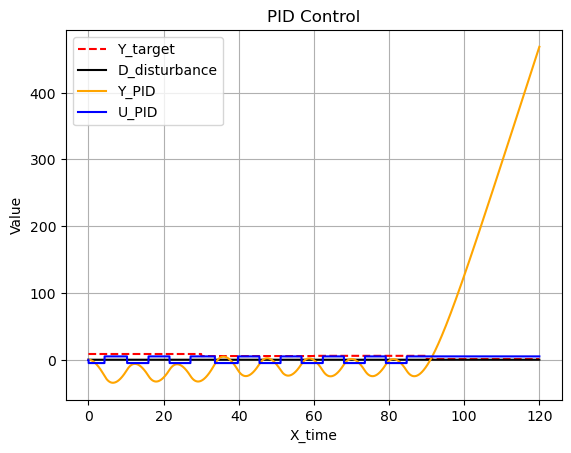

tensor([0.0000e+00, 2.0000e-02, 4.0000e-02,  ..., 1.1996e+02, 1.1998e+02,
        1.2000e+02])
tensor([ 0.0000, -1.2182, -1.4596,  ..., -1.0902, -1.0903, -1.0903])
tensor([ 0.0000,  0.9637,  1.6382,  ..., -0.1956, -0.1955, -0.1955])
tensor([ 0.0000, -1.1563, -1.1423,  ..., -0.2491, -0.2491, -0.2492])


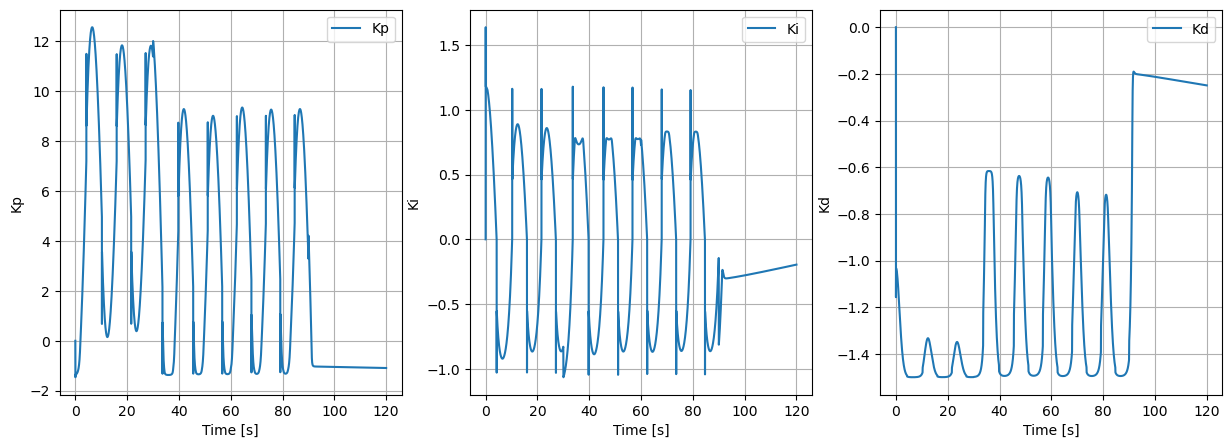

In [35]:
simulation.plot()
simulation.plot_K()

array([0., 0., 0., ..., 0., 0., 0.])